In [491]:

#!pip install statsmodels
#!pip install scikit-learn

In [1]:
import pandas as pd                                                 # type: ignore
import numpy as np                                                  # type: ignore
from sklearn.experimental import enable_iterative_imputer           # type: ignore
from sklearn.impute import IterativeImputer                         # type: ignore
from sklearn.model_selection import train_test_split                # type: ignore
import statsmodels.api as sm                                        # type: ignore
import seaborn as sns                                               # type: ignore
import matplotlib.pyplot as plt                                     # type: ignore
from statsmodels.datasets import get_rdataset                       # type: ignore
from sklearn.preprocessing import StandardScaler                    # type: ignore
from sklearn.decomposition import PCA                               # type: ignore
from sklearn.linear_model import LinearRegression                   # type: ignore

## a. Duplicados

In [493]:
airbnb = pd.read_csv("Base Airbnb NY.csv")
print(len(airbnb), "con duplicados")
airbnb.drop_duplicates(inplace=True)
print(len(airbnb), "sin duplicados")

48905 con duplicados
48895 sin duplicados


## b. Columnas irrelevantes

In [494]:
airbnb.drop(['id', 'name', 'host_id', 'host_name', 'last_review', 'neighbourhood'] , axis=1, inplace=True)
print(airbnb.dtypes)

neighbourhood_group                object
latitude                          float64
longitude                         float64
room_type                          object
price                             float64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object


## e. Variables Cualitativas

In [495]:
# Convierte las varaibles cualitativas en categorias 1, 2, etc
airbnb['room_type_v'] = airbnb['room_type'].astype('category').cat.codes
airbnb['neighbourhood_group_v'] = airbnb['neighbourhood_group'].astype('category').cat.codes

# Registra cual categoria era cual
room_type_cats=dict(enumerate(airbnb['room_type'].astype('category').cat.categories))
print("room_type", room_type_cats)

neighbourhood_group_cats = dict(enumerate(airbnb['neighbourhood_group'].astype('category').cat.categories))
print("neighbourhood_group: ", neighbourhood_group_cats)

airbnb.drop(['neighbourhood_group','room_type'], axis=1, inplace=True)

room_type {0: 'Entire home/apt', 1: 'Private room', 2: 'Shared room'}
neighbourhood_group:  {0: 'Bronx', 1: 'Brooklyn', 2: 'Manhattan', 3: 'Queens', 4: 'Staten Island'}


# d. Outliers

In [496]:
# valores que no tienen sentido : 0
print(airbnb['price'].iloc[26866])
print(np.min(airbnb['price']))
airbnb['price'].replace(0, np.nan, inplace=True)
print(np.min(airbnb['price']))


0.0
0.0
10.0


# c. Missing Values

In [497]:
# Determinamos cuántos missing values hay
print(airbnb.count())

# Soluciona los valores de reviews_per_month
airbnb.loc[airbnb['number_of_reviews'] == 0, 'reviews_per_month'] = 0
print("count reviews_per_month: ", airbnb['reviews_per_month'].count())

missing_rows = airbnb[airbnb.isnull().any(axis=1)]

# imputa missing values
lr = LinearRegression()
imp = IterativeImputer(estimator=lr, max_iter=30, random_state=0)
imputed_data = imp.fit_transform(airbnb)
airbnb = pd.DataFrame(imputed_data, columns=airbnb.columns, index=airbnb.index)

airbnb = airbnb[airbnb['price'] >= 0] # eliminamos los que no tienen sentido
print("min price", np.min(airbnb['price']))

latitude                          48895
longitude                         48895
price                             48869
minimum_nights                    48895
number_of_reviews                 48895
reviews_per_month                 38843
calculated_host_listings_count    48895
availability_365                  48895
room_type_v                       48895
neighbourhood_group_v             48895
dtype: int64
count reviews_per_month:  48895
min price 10.0


# f. Agrupar

In [498]:
c = airbnb.groupby('neighbourhood_group_v').size().reset_index(name='offer group')

airbnb = airbnb.merge(c, on='neighbourhood_group_v')
airbnb['offer group']

0        20103
1        20103
2        20103
3        20103
4        20103
         ...  
48889     1091
48890     1091
48891     1091
48892     1091
48893     1091
Name: offer group, Length: 48894, dtype: int64

PARTE 2

## A. Matriz de Correlación

In [499]:
#Dado que hay 10 variables, debemos tener una matriz de correlaciones de 10 x 10.
print(airbnb.dtypes)


latitude                          float64
longitude                         float64
price                             float64
minimum_nights                    float64
number_of_reviews                 float64
reviews_per_month                 float64
calculated_host_listings_count    float64
availability_365                  float64
room_type_v                       float64
neighbourhood_group_v             float64
offer group                         int64
dtype: object


In [500]:
#Creamos un df con los valores de cada variable dummy.
airbnb_d = pd.get_dummies(airbnb, columns=['room_type_v', 'neighbourhood_group_v'], prefix=['room_type_v', 'neighbourhood_group_v'])
airbnb_d

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,offer group,room_type_v_0.0,room_type_v_1.0,room_type_v_2.0,neighbourhood_group_v_0.0,neighbourhood_group_v_1.0,neighbourhood_group_v_2.0,neighbourhood_group_v_3.0,neighbourhood_group_v_4.0
0,40.64749,-73.97237,149.0,1.0,9.0,0.21,6.0,365.0,20103,False,True,False,False,True,False,False,False
1,40.68514,-73.95976,89.0,1.0,270.0,4.64,1.0,194.0,20103,True,False,False,False,True,False,False,False
2,40.68688,-73.95596,60.0,45.0,49.0,0.40,1.0,0.0,20103,False,True,False,False,True,False,False,False
3,40.66829,-73.98779,89.0,4.0,167.0,1.34,3.0,314.0,20103,False,True,False,False,True,False,False,False
4,40.70837,-73.95352,140.0,2.0,148.0,1.20,1.0,46.0,20103,True,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48889,40.83926,-73.91173,140.0,1.0,0.0,0.00,1.0,90.0,1091,False,True,False,True,False,False,False,False
48890,40.83146,-73.89666,80.0,7.0,0.0,0.00,1.0,71.0,1091,True,False,False,True,False,False,False,False
48891,40.83502,-73.91058,125.0,2.0,0.0,0.00,1.0,364.0,1091,False,True,False,True,False,False,False,False
48892,40.83372,-73.91187,70.0,2.0,0.0,0.00,2.0,81.0,1091,False,True,False,True,False,False,False,False


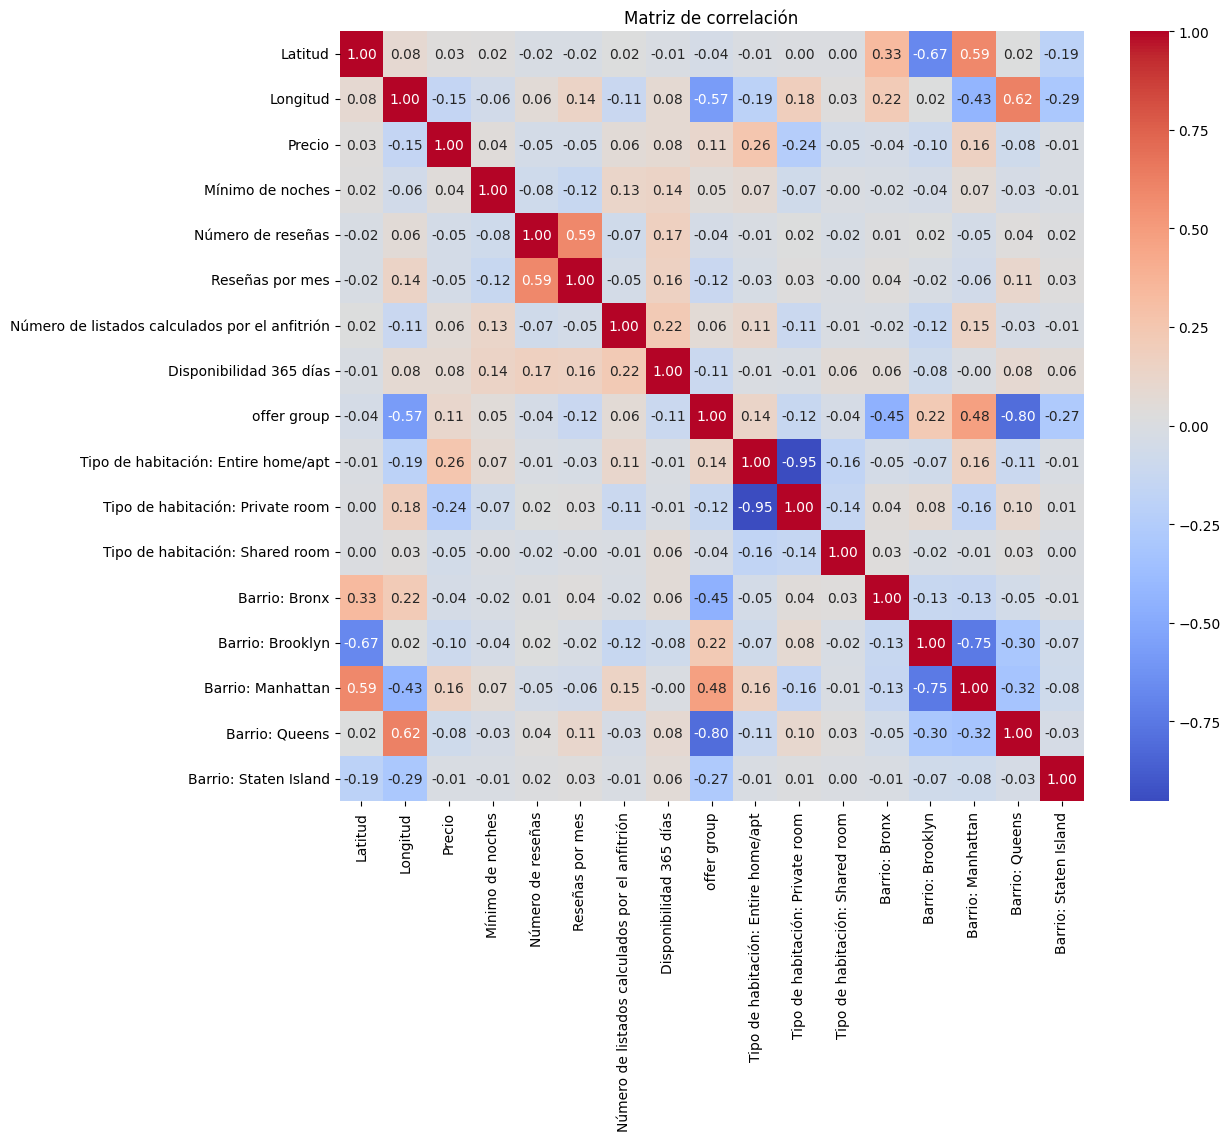

In [501]:
# Creamos nuestra matriz de correlacion
correlation_matrix = airbnb_d.corr()
# Cambiamos los nombres de las variables originales para mejorar la interpretación
correlation_matrix = correlation_matrix.rename(columns={'room_type_v_0.0': 'Tipo de habitación: Entire home/apt',
                                                      'room_type_v_1.0': 'Tipo de habitación: Private room',
                                                      'room_type_v_2.0': 'Tipo de habitación: Shared room',
                                                      'neighbourhood_group_v_0.0': 'Barrio: Bronx',
                                                      'neighbourhood_group_v_1.0': 'Barrio: Brooklyn',
                                                      'neighbourhood_group_v_2.0': 'Barrio: Manhattan',
                                                      'neighbourhood_group_v_3.0': 'Barrio: Queens',
                                                      'neighbourhood_group_v_4.0': 'Barrio: Staten Island',
                                                      'latitude': 'Latitud',
                                                      'longitude': 'Longitud',
                                                      'price': 'Precio',
                                                      'minimum_nights': 'Mínimo de noches',
                                                      'number_of_reviews': 'Número de reseñas',
                                                      'reviews_per_month': 'Reseñas por mes',
                                                      'calculated_host_listings_count': 'Número de listados calculados por el anfitrión',
                                                      'availability_365': 'Disponibilidad 365 días'})

# Transponemos la matriz de correlación para cambiar las etiquetas del eje vertical también
correlation_matrix = correlation_matrix.T

#  Cambiamos las etiquetas en el eje horizontal.
correlation_matrix = correlation_matrix.rename(columns={'room_type_v_0.0': 'Tipo de habitación: Entire home/apt',
                                                      'room_type_v_1.0': 'Tipo de habitación: Private room',
                                                      'room_type_v_2.0': 'Tipo de habitación: Shared room',
                                                      'neighbourhood_group_v_0.0': 'Barrio: Bronx',
                                                      'neighbourhood_group_v_1.0': 'Barrio: Brooklyn',
                                                      'neighbourhood_group_v_2.0': 'Barrio: Manhattan',
                                                      'neighbourhood_group_v_3.0': 'Barrio: Queens',
                                                      'neighbourhood_group_v_4.0': 'Barrio: Staten Island',
                                                      'latitude': 'Latitud',
                                                      'longitude': 'Longitud',
                                                      'price': 'Precio',
                                                      'minimum_nights': 'Mínimo de noches',
                                                      'number_of_reviews': 'Número de reseñas',
                                                      'reviews_per_month': 'Reseñas por mes',
                                                      'calculated_host_listings_count': 'Número de listados calculados por el anfitrión',
                                                      'availability_365': 'Disponibilidad 365 días'})

# Creamos el heatmap con los valores de la correlación impresos.
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación')
#Exportamos la matriz a png.
plt.savefig('matriz_correlacion.png', bbox_inches='tight')
plt.savefig('matriz_correlacion.pdf', bbox_inches='tight')
plt.show()


## B. Estadística descriptiva por Tipo de Barrio y Habitación

In [502]:
airbnb

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,room_type_v,neighbourhood_group_v,offer group
0,40.64749,-73.97237,149.0,1.0,9.0,0.21,6.0,365.0,1.0,1.0,20103
1,40.68514,-73.95976,89.0,1.0,270.0,4.64,1.0,194.0,0.0,1.0,20103
2,40.68688,-73.95596,60.0,45.0,49.0,0.40,1.0,0.0,1.0,1.0,20103
3,40.66829,-73.98779,89.0,4.0,167.0,1.34,3.0,314.0,1.0,1.0,20103
4,40.70837,-73.95352,140.0,2.0,148.0,1.20,1.0,46.0,0.0,1.0,20103
...,...,...,...,...,...,...,...,...,...,...,...
48889,40.83926,-73.91173,140.0,1.0,0.0,0.00,1.0,90.0,1.0,0.0,1091
48890,40.83146,-73.89666,80.0,7.0,0.0,0.00,1.0,71.0,0.0,0.0,1091
48891,40.83502,-73.91058,125.0,2.0,0.0,0.00,1.0,364.0,1.0,0.0,1091
48892,40.83372,-73.91187,70.0,2.0,0.0,0.00,2.0,81.0,1.0,0.0,1091


In [503]:
#Calculamos la frecuencia para cada tipo de alquiler
frequencia_room = airbnb['room_type_v'].value_counts()

# Armamos una tabla que imprima la frecuencia
table = pd.DataFrame({'Valor de room_type_v': frequencia_room.index, 'Frecuencia': frequencia_room.values})

# Ordenamos la tabla por el valor de room_type_v
table = table.sort_values(by='Valor de room_type_v')

print(table)


   Valor de room_type_v  Frecuencia
0                   0.0       25409
1                   1.0       22326
2                   2.0        1159


Cabe recordar que

0 --> Se alquila todo el departamento

1 --> Se alquila una habitación privada

2 --> Se alquila una habitación compartida

<ipython-input-504-aca903c0df79>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='room_type_v', data=airbnb, palette='Set2')
<ipython-input-504-aca903c0df79>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Piso Entero', 'Habitación Privada', 'Habitación Compartida'])


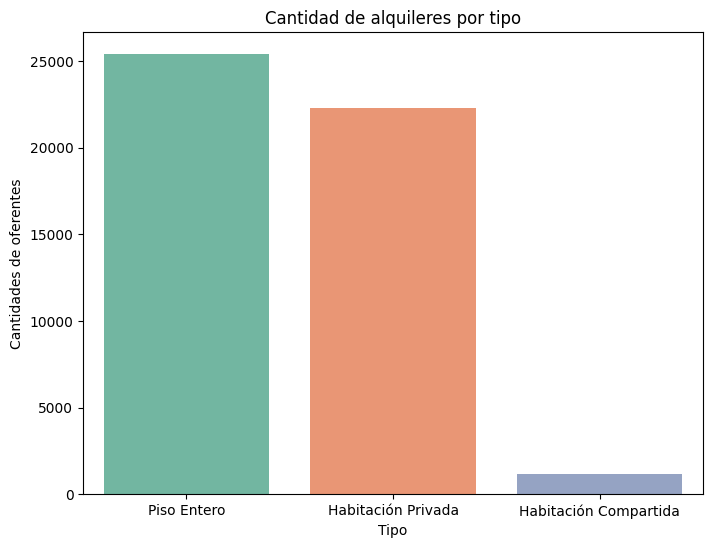

In [504]:
#Ahora graficamos la cantidad de oferentes por tipo de alquiler. ELegimos un gráfico de barras
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='room_type_v', data=airbnb, palette='Set2')
plt.title('Cantidad de alquileres por tipo')
plt.xlabel('Tipo')
plt.ylabel('Cantidades de oferentes')
ax.set_xticklabels(['Piso Entero', 'Habitación Privada', 'Habitación Compartida'])
#Expprtamos el gráfico
plt.savefig('alquileres_por_tipo.png')

plt.show()


In [505]:
#Analizamos la cantidad de oferentes por barrio
frequencia_barrio = airbnb['neighbourhood_group_v'].value_counts()

# Creamos una tabla a partir de las frecuencias
table_b = pd.DataFrame({'Valor de neighbourhood_group_v': frequencia_barrio.index, 'Frecuencia': frequencia_barrio.values})
table_b = table_b.sort_values(by='Valor de neighbourhood_group_v')
print(table_b)

   Valor de neighbourhood_group_v  Frecuencia
3                             0.0        1091
1                             1.0       20103
0                             2.0       21661
2                             3.0        5666
4                             4.0         373


<ipython-input-506-7af89a796338>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='neighbourhood_group_v', data=airbnb, palette='Set2')
<ipython-input-506-7af89a796338>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'])


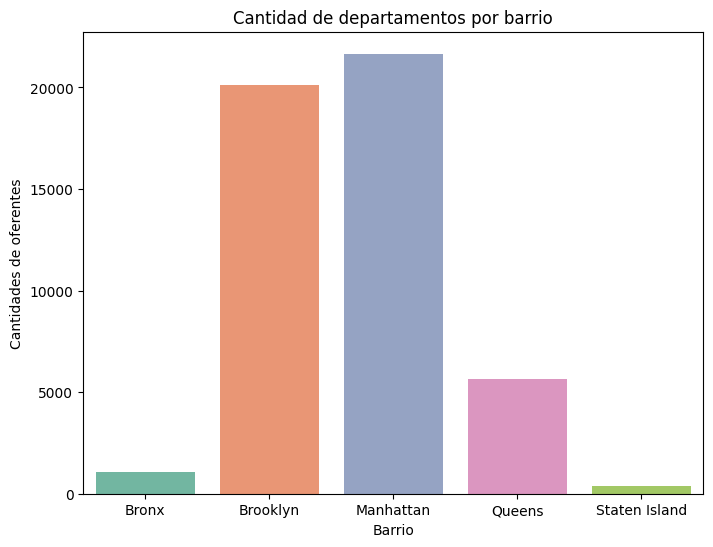

In [506]:
# Realizamos un gráfico de barras con la distribución de los barrios
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='neighbourhood_group_v', data=airbnb, palette='Set2')
plt.title('Cantidad de departamentos por barrio')
plt.xlabel('Barrio')
plt.ylabel('Cantidades de oferentes')

ax.set_xticklabels(['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'])
#Exportamos el gráfico
plt.savefig('alquileres_por_barrio.png')
plt.show()

# C. Histograma

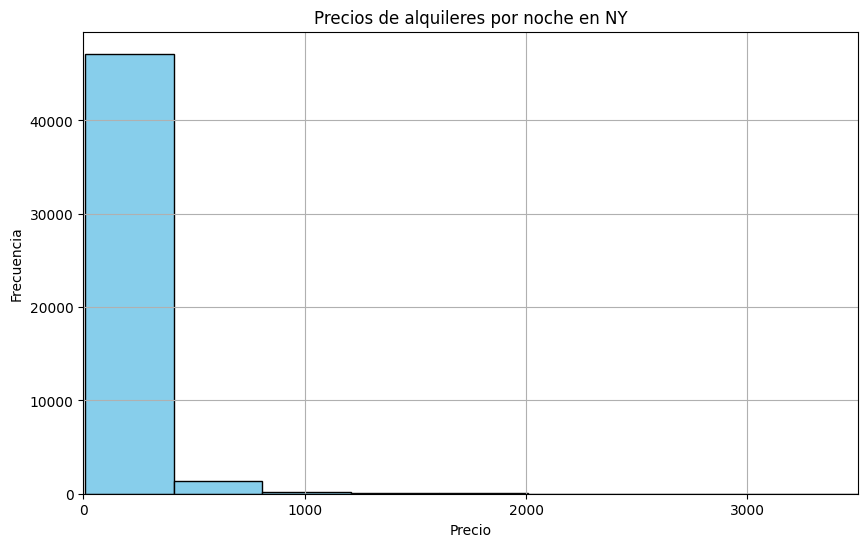

In [507]:
#Realizamos un histograma con la dispersión de precios. Limitamos el eje X a U$D 3.000
plt.figure(figsize=(10, 6))
plt.hist(airbnb['price'], bins=25, color='skyblue', edgecolor='black')
plt.title('Precios de alquileres por noche en NY')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.xlim(0, 3500)
plt.xticks(np.arange(0, 3001, 1000))
plt.grid(True)
#Exportamos el gráfico
plt.savefig('histograma_precios.png')

plt.show()

## Precios mínimos, máximos y media

In [508]:
#Dentro de la columna de precios, buscamos los valores mínimos, máximos y la media.
precio_minimo = airbnb['price'].min()
precio_maximo = airbnb['price'].max()
precio_promedio = airbnb['price'].mean()

print("Valor mínimo de 'price':", precio_minimo)
print("Valor máximo de 'price':", precio_maximo)
print("Valor promedio de 'price':", precio_promedio)

Valor mínimo de 'price': 10.0
Valor máximo de 'price': 10000.0
Valor promedio de 'price': 152.74780714256792


## Promedio condicional a las habitaciones y barrio

In [509]:
#Calculamos el precio promedio por cada tipo de habitación
promedio_por_tipo_habitacion = airbnb.groupby('room_type_v')['price'].mean()
print(promedio_por_tipo_habitacion)

room_type_v
0.0    211.814127
1.0     89.810450
2.0     70.196729
Name: price, dtype: float64


In [510]:
#Calculamos el precio promedio por cada tipo de habitación
promedio_por_barrio = airbnb.groupby('neighbourhood_group_v')['price'].mean()
print(promedio_por_barrio)

neighbourhood_group_v
0.0     87.602552
1.0    124.423444
2.0    196.891301
3.0     99.524343
4.0    114.812332
Name: price, dtype: float64


# d. Scatter plots

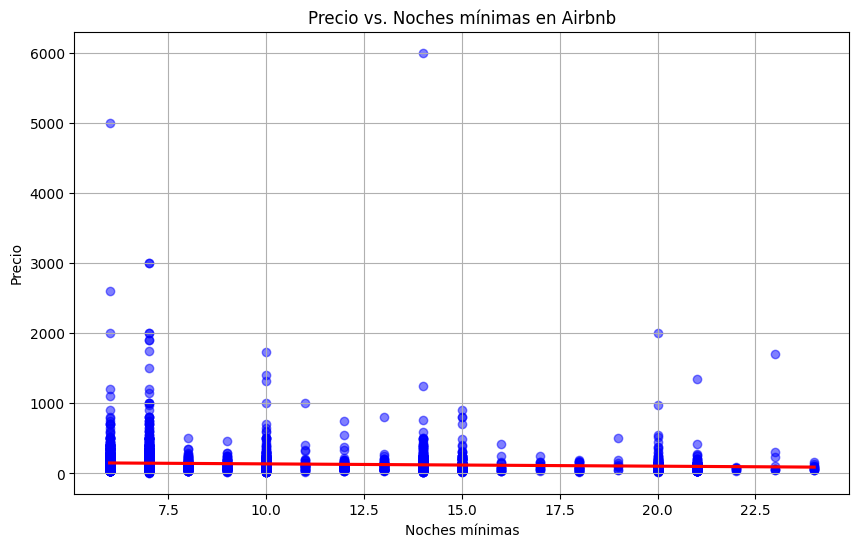

In [511]:
# Creamos un nuevo df con los valores de 'minimum_nights' que sean mayores a 5 pero menores a 25. Es decir, aquellos alquileres que requieran noches mínimas de reserva pero no en exceso.
airbnb_mn = airbnb[(airbnb['minimum_nights'] > 5) & (airbnb['minimum_nights'] < 25)]

# Creamos el scatter plot con la variable modificada
plt.figure(figsize=(10, 6))
sns.regplot(x='minimum_nights', y='price', data=airbnb_mn, scatter_kws={'alpha':0.5, 'color':'blue'}, line_kws={'color':'red'})
plt.title('Precio vs. Noches mínimas en Airbnb')
plt.xlabel('Noches mínimas')
plt.ylabel('Precio')
plt.grid(True)
plt.savefig('precio_reserva_minima.png')
plt.show()


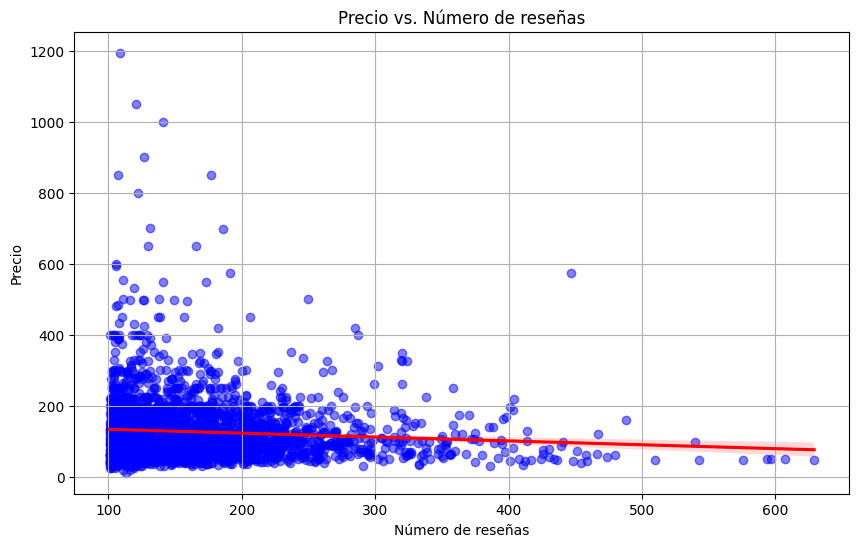

In [512]:
#En este segudo gráfico, estamos relacionando las reseñas recibidas con el precio del inmueble a alquilar. Nos quedamos con los departamentos con más de 100 reseñas
airbnb_reviews = airbnb[(airbnb['number_of_reviews'] > 100)]

plt.figure(figsize=(10, 6))
sns.regplot(x='number_of_reviews', y='price', data=airbnb_reviews, scatter_kws={'alpha':0.5, 'color':'blue'}, line_kws={'color':'red'})
plt.title('Precio vs. Número de reseñas')
plt.xlabel('Número de reseñas')
plt.ylabel('Precio')
plt.grid(True)
plt.savefig('precio_reseñas.png')
plt.show()

## e. PCA

In [513]:
airbnb

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,room_type_v,neighbourhood_group_v,offer group
0,40.64749,-73.97237,149.0,1.0,9.0,0.21,6.0,365.0,1.0,1.0,20103
1,40.68514,-73.95976,89.0,1.0,270.0,4.64,1.0,194.0,0.0,1.0,20103
2,40.68688,-73.95596,60.0,45.0,49.0,0.40,1.0,0.0,1.0,1.0,20103
3,40.66829,-73.98779,89.0,4.0,167.0,1.34,3.0,314.0,1.0,1.0,20103
4,40.70837,-73.95352,140.0,2.0,148.0,1.20,1.0,46.0,0.0,1.0,20103
...,...,...,...,...,...,...,...,...,...,...,...
48889,40.83926,-73.91173,140.0,1.0,0.0,0.00,1.0,90.0,1.0,0.0,1091
48890,40.83146,-73.89666,80.0,7.0,0.0,0.00,1.0,71.0,0.0,0.0,1091
48891,40.83502,-73.91058,125.0,2.0,0.0,0.00,1.0,364.0,1.0,0.0,1091
48892,40.83372,-73.91187,70.0,2.0,0.0,0.00,2.0,81.0,1.0,0.0,1091


In [514]:
#En primer lugar, estandarizamos las variables
scaler = StandardScaler(with_std=True, with_mean=True)
airbnb_estandarizado = pd.DataFrame(scaler.fit_transform(airbnb), columns=airbnb.columns)
print(airbnb_estandarizado.mean()) #Verificamos la media de los datos
print(airbnb_estandarizado.std()) #Verificados el desvio estandar.

latitude                          1.287214e-14
longitude                        -2.975473e-13
price                            -8.835644e-17
minimum_nights                    6.975509e-18
number_of_reviews                -2.092653e-17
reviews_per_month                -5.580407e-17
calculated_host_listings_count   -1.162585e-17
availability_365                  8.370610e-17
room_type_v                      -1.162585e-16
neighbourhood_group_v             1.488108e-16
offer group                       2.976217e-16
dtype: float64
latitude                          1.00001
longitude                         1.00001
price                             1.00001
minimum_nights                    1.00001
number_of_reviews                 1.00001
reviews_per_month                 1.00001
calculated_host_listings_count    1.00001
availability_365                  1.00001
room_type_v                       1.00001
neighbourhood_group_v             1.00001
offer group                       1.00001
dtype:

In [515]:
#Una vez que estandarizamos las variables, realizamos Análisis de Componentes Principales
pca = PCA()
airbnb_pca = pca.fit_transform(airbnb_estandarizado)
# Scores
scores = airbnb_pca
#Varianza explicada de cada componente
print("Varianza explicada:", pca.explained_variance_ratio_)
# Loadings vectors
loading_vectors = pca.components_ # cada fila corresponde a un CP y cada columna, a una variable
print("Loadings:\n", pca.components_)
print("Loadings del CP1:\n",pca.components_[0])
print("Loadings del CP2:\n",pca.components_[1])

Varianza explicada: [0.18558515 0.14138131 0.1360462  0.10576503 0.08947655 0.08000013
 0.07351376 0.06539208 0.05627779 0.03650644 0.03005556]
Loadings:
 [[ 0.11000543  0.49239874 -0.1969033  -0.13008241  0.32111273  0.38193628
  -0.1162048   0.17288603  0.23204708  0.27774518 -0.51612001]
 [-0.25473908 -0.24221185  0.05763944 -0.11326398  0.5830304   0.53296622
  -0.01695626  0.16268948 -0.12397437 -0.3080031   0.31515395]
 [ 0.23959395 -0.09185964  0.37277615  0.33008745  0.07384234  0.07311956
   0.4642032   0.45422518 -0.33377762  0.37158934 -0.06439213]
 [-0.4250068   0.11886672 -0.3339001   0.38935249 -0.10522822 -0.1114433
   0.34013558  0.42978134  0.34408429 -0.31316781 -0.04231334]
 [-0.59512718  0.29259405  0.45730728 -0.10366682 -0.13134734 -0.07335323
  -0.16400582  0.04538417 -0.39900917 -0.13677688 -0.33290978]
 [ 0.14617582  0.09993718  0.06439688  0.77080055  0.13472886  0.02744416
  -0.57249583 -0.06419956 -0.0718089  -0.1178032   0.02350584]
 [ 0.21029808  0.0336593

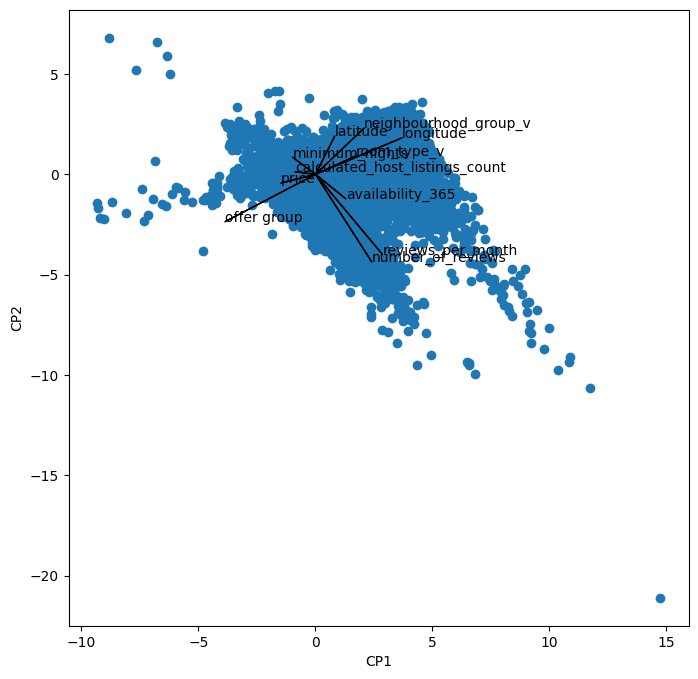

<Figure size 640x480 with 0 Axes>

In [516]:
# Biplot
scale_arrow = s_ = 7.5
scores [:,1] *= -1
pca.components_[1] *= -1
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(scores [:,0], scores[:,1])
ax. set_xlabel('CP1')
ax. set_ylabel( 'CP2')
for k in range(pca.components_.shape[1]):
  ax.arrow(0, 0, s_*pca.components_[0, k], s_*pca.components_[1,k])
  ax.text(s_*pca.components_[0,k], s_*pca.components_[1,k], airbnb.columns[k] )
plt.show()

plt.savefig('pca_2.png')

In [517]:
# % de la Varianza explicada por los componentes
print(pca.explained_variance_ratio_) # CP1 explica el 18% de la varianza, CP2 el 14%

[0.18558515 0.14138131 0.1360462  0.10576503 0.08947655 0.08000013
 0.07351376 0.06539208 0.05627779 0.03650644 0.03005556]


# Parte III

In [518]:
airbnb
Y=airbnb['price']
X=airbnb.drop('price', axis=1)
dfY=pd.DataFrame(Y)
X

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,room_type_v,neighbourhood_group_v,offer group
0,40.64749,-73.97237,1.0,9.0,0.21,6.0,365.0,1.0,1.0,20103
1,40.68514,-73.95976,1.0,270.0,4.64,1.0,194.0,0.0,1.0,20103
2,40.68688,-73.95596,45.0,49.0,0.40,1.0,0.0,1.0,1.0,20103
3,40.66829,-73.98779,4.0,167.0,1.34,3.0,314.0,1.0,1.0,20103
4,40.70837,-73.95352,2.0,148.0,1.20,1.0,46.0,0.0,1.0,20103
...,...,...,...,...,...,...,...,...,...,...
48889,40.83926,-73.91173,1.0,0.0,0.00,1.0,90.0,1.0,0.0,1091
48890,40.83146,-73.89666,7.0,0.0,0.00,1.0,71.0,0.0,0.0,1091
48891,40.83502,-73.91058,2.0,0.0,0.00,1.0,364.0,1.0,0.0,1091
48892,40.83372,-73.91187,2.0,0.0,0.00,2.0,81.0,1.0,0.0,1091


In [519]:
X_train, X_test, y_train, y_test = train_test_split(X, dfY, test_size=0.3, random_state=201)

In [520]:
print(X_test)
print(y_test)

       latitude  longitude  minimum_nights  number_of_reviews  \
28434  40.82852  -73.94583             7.0                9.0   
6180   40.68696  -73.91382             2.0              179.0   
29876  40.75382  -73.97192             3.0                4.0   
37224  40.72333  -73.97934             2.0                3.0   
42171  40.76496  -73.91169            31.0                5.0   
...         ...        ...             ...                ...   
15028  40.68387  -73.94162             3.0               44.0   
37222  40.78191  -73.95292             3.0               11.0   
43490  40.77307  -73.91822             3.0                3.0   
37108  40.73854  -73.99695            30.0                0.0   
9338   40.64250  -73.94293             2.0               11.0   

       reviews_per_month  calculated_host_listings_count  availability_365  \
28434               0.25                             1.0              27.0   
6180                4.47                             1.0       

Vemos que ahora tenemos 14669 columnas (observaciones) para 1 variable dependiente y 10 regresores.

In [521]:
#Cambiamos el nombre de las columnas para que sean entendibles en la regresión
X_test = X_test.rename(columns={'room_type_v': 'Tipo de habitación',
                                                      'neighbourhood_group_v': 'Barrio',
                                                      'latitude': 'Latitud',
                                                      'longitude': 'Longitud',
                                                      'minimum_nights': 'Mínimo de noches',
                                                      'number_of_reviews': 'Número de reseñas',
                                                      'reviews_per_month': 'Reseñas por mes',
                                                      'calculated_host_listings_count': 'Número de listados calculados por el anfitrión',
                                                      'availability_365': 'Disponibilidad 365 días',
                              'offer group': 'Oferentes por barrio'})
#Agregamos la constante
X_test=sm.add_constant(X_test)
#Regresamos nuestras variables
OLS=sm.OLS(y_test, X_test)
#Guardamos los resultados
resultados=OLS.fit()

latex_table = resultados.summary().as_latex()

#Exportamos como tabla para latex, presente en el pdf entregado
with open('resultados.tex', 'w') as file:
    file.write(latex_table)


